# Homework 2, Tristan Moser

# Kaggle Competition: Predicting House Prices

To begin this competition, I import as modules necessary for the cleaning and modeling.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm

from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor

## Data

Kaggle provided me with both training and test datasets. Here, I read them in.   

It is important to note that I do not explicitly doctor the test data. It is read in and cleaned using the same method and procedure as that undertaken by the training set. This way there is no unfair bias brought into the model creation later on.

In [2]:
#Training Data
all_train_data = pd.read_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/train.csv")

#Test Data
all_test_data = pd.read_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/test.csv")

First, it is important to examine the training data to see what potential problems we could have with the data.

In [3]:
all_train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Upon initial examinization, it appears that there are two immediate problems with the data:   
 - Skewness of the columns
 - Missing Datapoints   
   
   
### Skewness
Skewness indicates that the column is heavily weighted towards one value which would limit the variance of the variable. This can be troublesome and with most values lying in one value it is likely that the usefulness of the variable is low.   

To correct for this, I drop all columns with sever skewness. I use 70% as the cut-off value.

In [4]:
#Compile columns with severe skewness in the training set
to_drop = []
for ii in all_train_data:
    if all_train_data[ii].value_counts(normalize=True, dropna=False).iloc[0] > .7:
           to_drop.append(ii)

The same columns are dropped from both the training and test sets so that each set has the same variables.

In [5]:
#Drop all columns with more than 70% skewness
all_train_data_2 = all_train_data.drop(to_drop, axis=1)

all_test_data_2 = all_test_data.drop(to_drop,axis=1)

   ### Missing Values
   Now, I move to correct the problem of missing values.  
   
   First, I split the datasets into two parts. One for categorical variables and one for non-categorical variables. I do this becuase of the different techniques I will use for filling the null values.   
      
Once the datasets are split, I compile the list of variables that have missing values and fill in the missing values with the appropriate value based on information from the Kaggle Data Description or with the use of an Imputer in the case of non-categorical data.

#### Categorical Variables

In [6]:
#Split data into categorical variables and non-categorical
categorical = all_train_data_2.select_dtypes(include = ['object'])
non_cat = all_train_data_2.select_dtypes(exclude = ['object'])

test_cat = all_test_data_2.select_dtypes(include = ['object'])
test_non_cat = all_test_data_2.select_dtypes(exclude = ['object'])

#Examine categorical data for missing values or other concerns
categorical.describe()

,LotShape,Neighborhood,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
count,1460,1460,1460,1460,1460,1452,1460,1460,1423,1422,1423,1460,1460,770,1379,1379
unique,4,25,8,15,16,4,4,6,4,4,6,5,4,5,6,3
top,Reg,NAmes,1Story,VinylSd,VinylSd,None,TA,PConc,TA,No,Unf,Ex,TA,Gd,Attchd,Unf
freq,925,225,726,515,504,864,906,647,649,953,430,741,735,380,870,605


In [7]:
#Compile columns with missing values
cat_nans = []
for ll in categorical:
    if categorical[ll].isnull().any() == True:
        cat_nans.append(ll)

#Show columns
cat_nans

['MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

Each of these variables show in the Kaggle Data Description that a null value indicates that the observation does not have the specified feature. As such, I will replace the null values with "None".

In [8]:
#Fill nan values with "None" as indicated by data description on Kaggle
categorical_no_nas = categorical.fillna(value = "None")

#Verify that no missing values remain
categorical_no_nas.describe()

,LotShape,Neighborhood,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,4,25,8,15,16,4,4,6,5,5,7,5,4,6,7,4
top,Reg,NAmes,1Story,VinylSd,VinylSd,None,TA,PConc,TA,No,Unf,Ex,TA,None,Attchd,Unf
freq,925,225,726,515,504,872,906,647,649,953,430,741,735,690,870,605


I now repeat the process with the test dataset.

In [9]:
#Compile columns with missing values
test_cat_nans = []
for mm in test_cat:
    if test_cat[mm].isnull().any() == True:
        test_cat_nans.append(mm)

#Show columns        
test_cat_nans

['Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish']

Three of these columns differ from the ones with missing values in the training set.   
 - Exterior1st
 - Exterior2nd
 - KitchenQual
   
They do not contain the option to be "None", so I look at their most common value and place that in for the missing values.

In [10]:
#Find most common value for Exterior1st
test_cat['Exterior1st'].describe()

count        1458
unique         13
top       VinylSd
freq          510
Name: Exterior1st, dtype: object

In [11]:
#Find most common value for Exterior2nd
test_cat['Exterior2nd'].describe()

count        1458
unique         15
top       VinylSd
freq          510
Name: Exterior2nd, dtype: object

In [12]:
#Find most common value for KitchenQual
test_cat['KitchenQual'].describe()

count     1458
unique       4
top         TA
freq       757
Name: KitchenQual, dtype: object

In [13]:
#Replace missing values with the appropriate value
test_cat_nona = test_cat.fillna(value = {
    "Exterior1st": "VinylSd",
    "Exterior2nd": "VinylSd",
    "MasVnrType": "None",
    "BsmtQual": "None",
    "BsmtExposure": "None",
    "BsmtFinType1": "None",
    "KitchenQual": "TA",
    "FireplaceQu": "None",
    "GarageType": "None",
    "GarageFinish": "None"
})

#### Non-Categorical Variables   
   
Because these variables are continuous in nature, there is no specific value for them to take on. As such, I will use an imputer to calculate an estimated value based on the means of each variable.

In [14]:
#Look at non-categorical variables for potential missing values
non_cat.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,12.000000,2010.000000,755000.000000


In [15]:
#Compile columns that contain missing values
fill_missing = []
for jj in non_cat:
    if non_cat[jj].isnull().any() == True:
        fill_missing.append(jj)

#Show columns
fill_missing

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [16]:
#Examine variables with missing values
non_cat[fill_missing].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [17]:
#Compile columns that contain missing values
test_fill_missing = []
for jj in test_non_cat:
    if test_non_cat[jj].isnull().any() == True:
        test_fill_missing.append(jj)
test_fill_missing

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [18]:
#Because we cannot determine what exact values each observation has, I impute the missing data points
impute = Imputer()
non_cat_imputed = impute.fit_transform(non_cat)

test_non_cat_imputed = impute.fit_transform(test_non_cat)

A fun fact about the imputer function is that it removes the column names from the dataframe. So, I now compile a list of the column names before the values were imputed. Then, I can recreate the dataframe using the correct column names.

In [19]:
#Compile the column names
non_cat_columns = []
for cc in non_cat:
    non_cat_columns.append(cc)

test_non_cat_columns = []
for uu in test_non_cat:
    test_non_cat_columns.append(uu)

In [20]:
#recreate dataframe and verify that the missing values have been imputed
df_imputed = pd.DataFrame(non_cat_imputed,columns=non_cat_columns)

test_df_imputed = pd.DataFrame(test_non_cat_imputed, columns = test_non_cat_columns)

df_imputed[fill_missing].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1460.000000,1460.000000,1460.000000
mean,70.049958,103.685262,1978.506164
std,22.024023,180.569112,23.994583
min,21.000000,0.000000,1900.000000
25%,60.000000,0.000000,1962.000000
50%,70.049958,0.000000,1978.506164
75%,79.000000,164.250000,2001.000000
max,313.000000,1600.000000,2010.000000


## Final Data Cleaning   
   
Now that the problems of skewness and missing values are accounted for, I combine the categorical and non-categorical variables back into one dataframe.   
   
I then examine the normality of the SalePrice, our target feature, and make necessary adjustments. Dummy variables are also created.   
   
Finally, I look at potential outliers and eliminate them if needed.

In [21]:
#Combine categorical and non-categorical variables back into one dataframe
modified_train_data = pd.concat([df_imputed,categorical_no_nas],axis=1)

modified_test_data = pd.concat([test_df_imputed,test_cat_nona],axis=1)

modified_train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,Gd,PConc,Gd,No,GLQ,Ex,Gd,None,Attchd,RFn
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,TA,CBlock,Gd,Gd,ALQ,Ex,TA,TA,Attchd,RFn
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,Gd,PConc,Gd,Mn,GLQ,Ex,Gd,TA,Attchd,RFn
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,TA,BrkTil,TA,No,ALQ,Gd,Gd,Gd,Detchd,Unf
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,Gd,PConc,Gd,Av,GLQ,Ex,Gd,TA,Attchd,RFn


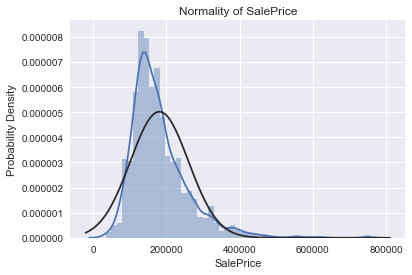

In [22]:
#Examine normality of SalePrice
sns.distplot(modified_train_data['SalePrice'],fit=norm)
plt.title("Normality of SalePrice")
plt.ylabel("Probability Density")

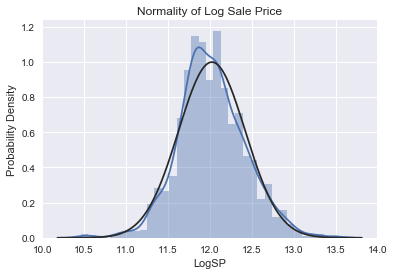

In [23]:
#Log SalePrice and examine normality
modified_train_data['LogSP'] = np.log(modified_train_data['SalePrice'])
sns.distplot(modified_train_data['LogSP'],fit=norm)
plt.title("Normality of Log Sale Price")
plt.ylabel("Probability Density")

Clearly, the Log Sale Price has a stonger normal distribution which will benefit the linear regression model soon to come.   
   
Now, I examine regression plots for each variable against LogSP and "eye ball" potential outliers.   
   
This will help with the linear regression model as it is very sensitive to outliers. Also, it is importnant to note that the regplots will also show if there is a linear relationship between the variables and LogSP. Another assumption for linear regression.

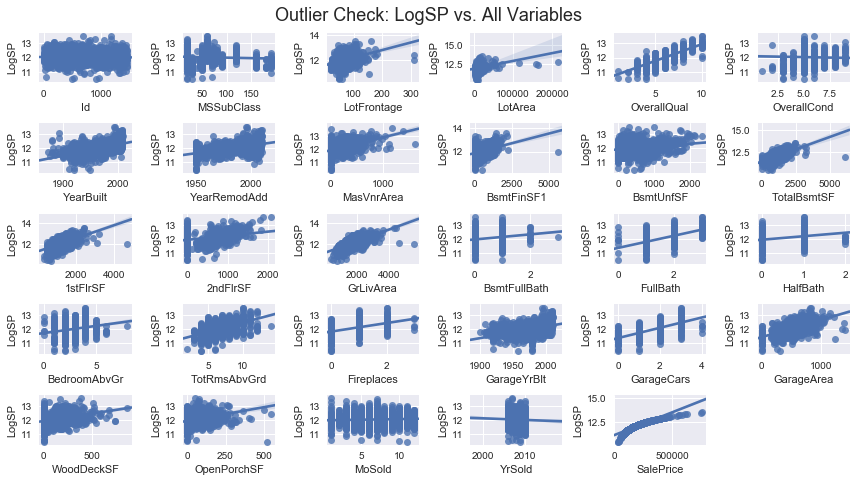

In [24]:
fig = plt.figure(figsize=(12,7))
#Create a regplot for each variable with LogSP
for i in np.arange(29):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=df_imputed.iloc[:,i], y=modified_train_data['LogSP'])

#The title will not display correctly unless the rect dimensions are specified
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Outlier Check: LogSP vs. All Variables", fontsize = 18)
plt.show()

Using the visual examination, I now remove the significant outliers by dropping the outlier observations.

In [25]:
#Remove obvious outliers based on regplots
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['LotFrontage']>300)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['BsmtFinSF1']>5000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['TotalBsmtSF']>5000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['1stFlrSF']>4000)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['GrLivArea']>4000) & (modified_train_data['LogSP']<12.5)].index)
modified_train_data = modified_train_data.drop(modified_train_data[(modified_train_data['OpenPorchSF']>500) & (modified_train_data['LogSP']<11)].index)

To check to make sure that the appropriate outliers have been removed, I repeat the process and perform a visual examination again.

In [26]:
outlier_check = modified_train_data.select_dtypes(exclude = ['object'])

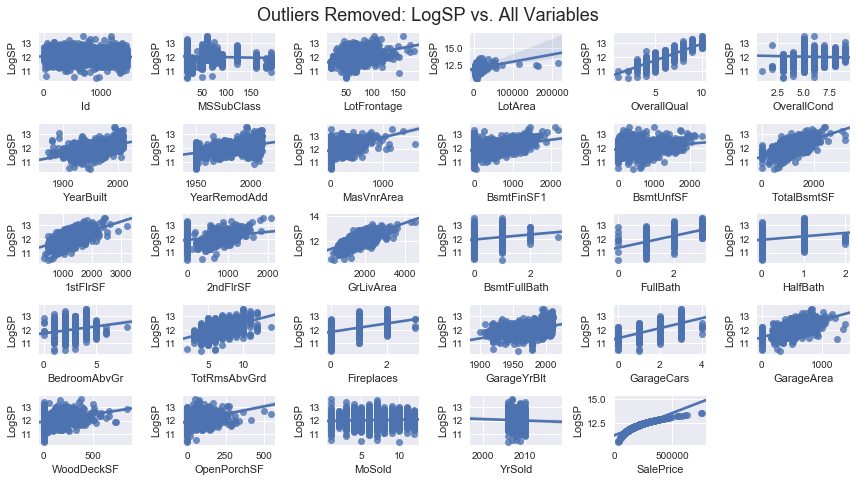

In [27]:
fig = plt.figure(figsize=(12,7))
#Create a regplot for each variable with LogSP
for i in np.arange(29):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=outlier_check.iloc[:,i], y=modified_train_data['LogSP'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Outliers Removed: LogSP vs. All Variables", fontsize = 18)
plt.show()

### Create Dummy Variables   
   
Now that outliers are accounted for, dummy variables will be created for each categorical variable so that the models can more easily interpret the information they contain.

In [28]:
#Get Dummies
dummies_train_data = pd.get_dummies(modified_train_data)

#Drop SalePrice because it has been replaced with LogSP
final_train_data = dummies_train_data.drop(['SalePrice'],axis=1)

#Get Dummies for Test data
final_test_data = pd.get_dummies(modified_test_data)

#Examine how many variables will be feed to the model
final_train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,1,0,0,0,0,0,0,0,1,0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,1,0,0,0,0,0,0,0,1,0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0,0,0,0,1,0,0,0,0,1
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,1,0,0,0,0,0,0,0,1,0


## Modeling   
   
The data is now cleaned and ready to be used to create an appropriate model that will estimate the sale price of houses given predicting variables.   
   
I will split the training data into train and test sets so that cross validation can be implemented. I then use a scaler to scale my training set to fit a normal distribution and transform the test set accordingly.

The following models are examined:   
 - Standard Gradient Descent
 - Elastic Net
 - Descision Tree Regressor
 - Random Forest Regressor

In [29]:
#divide train data into target and predictors
target = final_train_data['LogSP']
predictors = final_train_data.drop(['LogSP'],axis=1)

In [30]:
#Split train data for cross validation
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=42)

In [31]:
#The scaler will fit the data to a normal distribution. i.e. subract the mean and divide by the standard deviation
scaler = StandardScaler()
#Fit the x_train data
scaler.fit(x_train)
#Transform both x_train and x_test with the scaler fitted to the x_train
scaled_data = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

### Standard Gradient Descent   
   
The main assumption for this model is that of linear relationships between the predictors and the target, and the normality assumption. Both of these have been looked at earlier while examining outliers in the data.

In [32]:
model = SGDRegressor()
#eta0 is the initial learning rate. i.e. How much to move in the direction of the negative gradient
potential_params = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}
#The gridsearch will average across each combination of parameters using cross validation to select best parameters
gridsearch = GridSearchCV(model,param_grid=potential_params,cv=3,scoring='neg_mean_squared_error' )
#fit 
gridsearch.fit(scaled_data,y_train)
print("Best Params: {}".format(gridsearch.best_params_))

Best Params: {'eta0': 0.003}


In [33]:
#This block of code is used use our fitted model to predict values on train and test 
train_predictions = gridsearch.predict(scaled_data)
test_predictions = gridsearch.predict(scaled_test)

#I use Root Mean Squared Errors as the metric of evaluation
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train RMSE: {}".format(train_rmse))
print("Test RMSE: {}".format(test_rmse))

Train RMSE: 1.0139143612012196
Test RMSE: 1.0093546664558144


The Root Mean Squared Error tells us how far away our predictions are from their actual value on average. This is a great way to see how well the model performs. In particular, these RMSE seem quite large considering that they are measured in the log of the sale price. An RMSE of 1 can be large considering that e^11 is approximately 60,000 and e^12 is approximately 162,000. An average distance of 100,000 means that this model is not very accurate.   
   
I believe that adding more complex attributes to this model, namely regularization, will help lower the RMSE.

### Elastic Net

The Elastic Net model will take into account L1 (Lasso) and L2 (Ridge) regularization techniques to ensure that the model is penalized for coefficients that are too large. This should help the create more accurate predictions than the Gradient Descent model could accomplish on its own.

In [34]:
#ElasticNetCV works the same as GridSearchCV and will exhaustively search and find the best parameters
ENSTest = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=5000).fit(scaled_data, y_train)
print("Best Alpha: {}".format(ENSTest.alpha_))
print("Best L1/L2 Ratio: {}".format(ENSTest.l1_ratio_))
train_predictions1 = ENSTest.predict(scaled_data)
test_predictions1 = ENSTest.predict(scaled_test)

#Check how well the model predicts and look for over-fitting
train_rmse2 = np.sqrt(mean_squared_error(y_train, train_predictions1))
test_rmse2 = np.sqrt(mean_squared_error(y_test, test_predictions1))
print("Train RMSE: {}".format(train_rmse2))
print("Test RMSE: {}".format(test_rmse2))

Best Alpha: 0.01
Best L1/L2 Ratio: 0.5
Train RMSE: 0.10793022695174892
Test RMSE: 0.12534278698428467


The RSMEs are significantly lower than that of Gradient Descent. 0.1 translates to about a 10,000 dollar difference on average for the estimates which is a lot closer. There does not appear to be any evidence of over-fitting here as both RMSE of the train and test are similar.

In [35]:
#Look at how the predicted prices look
np.exp(ENSTest.predict(scaled_test)[0:5])

array([ 132468.51969052,  165407.87790212,  129503.02287905,
        105410.69527709,  321409.92221098])

To see which variable in the model have the most impact in prediction, I plot the absoute values of the coefficients.

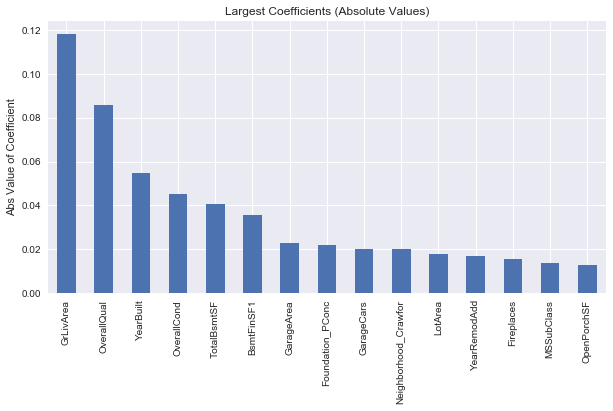

In [36]:
#Calculate and plot coefficients
coefficients = np.abs(ENSTest.coef_)
series_coef = pd.Series(np.abs(ENSTest.coef_),index = x_train.columns)
largest_coef = series_coef.nlargest(n=15)
largest_coef.plot(kind='bar',title = "Largest Coefficients (Absolute Values)",figsize=(10,5))
plt.ylabel('Abs Value of Coefficient')

### Decision Tree and Random Forest Regressors

These two models do not follow the same internal structure as GD or Elastic Net, but they may be able to provide nice estimates as well for the housing prices.    
   
I use gridsearches for both models to see what the best parameters would be. Then, the same steps as taken with the previous models to evaluate the RMSE are taken.

In [37]:
tree = DecisionTreeRegressor()
depths = {"max_depth": [3,4,5,6,7,8]}
gridsearch2 = GridSearchCV(tree,param_grid=depths,cv=4,scoring='neg_mean_squared_error')
gridsearch2.fit(scaled_data,y_train)
print("Best Params: {}".format(gridsearch2.best_params_))

Best Params: {'max_depth': 7}


In [38]:
train_predictions2 = gridsearch2.predict(scaled_data)
test_predictions2 = gridsearch2.predict(scaled_test)

train_rmse3 = np.sqrt(mean_squared_error(y_train, train_predictions2))
test_rmse3 = np.sqrt(mean_squared_error(y_test, test_predictions2))
print("Train RMSE: {}".format(train_rmse3))
print("Test RMSE: {}".format(test_rmse3))

Train RMSE: 0.09694444935543556
Test RMSE: 0.20107718300625432


The RMSE here are low, but not lower than the Elastic Net. Therefore, I will move on to Random Forest.

In [39]:
forest = RandomForestRegressor()
forest_params = {"n_estimators":[100,500,1000], "max_depth": [3,5,8,10,12,13,15],}
gridsearch3 = GridSearchCV(forest,param_grid=forest_params,cv=4,scoring='neg_mean_squared_error')
gridsearch3.fit(scaled_data,y_train)
print("Best Params: {}".format(gridsearch3.best_params_))

Best Params: {'max_depth': 13, 'n_estimators': 100}


In [40]:
train_predictions3 = gridsearch3.predict(scaled_data)
test_predictions3 = gridsearch3.predict(scaled_test)

train_rmse4 = np.sqrt(mean_squared_error(y_train, train_predictions3))
test_rmse4 = np.sqrt(mean_squared_error(y_test, test_predictions3))
print("Train RMSE: {}".format(train_rmse4))
print("Test RMSE: {}".format(test_rmse4))

Train RMSE: 0.05265640701309646
Test RMSE: 0.14012850327713153


The RMSE for this model is close to the same as that of Elastic Net. It may be a good estimator, but I do also worry that some overfitting is coming from this model as it predicts better on the train data than the test.   
   
To try and counteract that overfitting, I reduce the complexity of the random forest regression by limiting the depth and number of estimators

In [41]:
#Recreate random forest model with lower hyper-parameters
forest_2 = RandomForestRegressor(n_estimators=350,max_depth=10)
forest_2.fit(scaled_data,y_train)

train_predictions4 = forest_2.predict(scaled_data)
test_predictions4 = forest_2.predict(scaled_test)

train_rmse5 = np.sqrt(mean_squared_error(y_train, train_predictions4))
test_rmse5 = np.sqrt(mean_squared_error(y_test, test_predictions4))
print("Train RMSE: {}".format(train_rmse5))
print("Test RMSE: {}".format(test_rmse5))

Train RMSE: 0.05767678302192537
Test RMSE: 0.1383408443372733


Upon various attempts at different hyper-parameters, it appears that the RMSEs do not flucuate much around 0.06 for train and 0.14 for test.

In [42]:
#Look at price estimates
np.exp(gridsearch3.predict(scaled_test)[0:5])

array([ 125421.28851058,  173993.1404417 ,  146894.51068074,
         99959.27669886,  295043.00582421])

Now, I look at the most influential features from the random forest regression and compare them to the highest coefficients of the Elastic Net model.

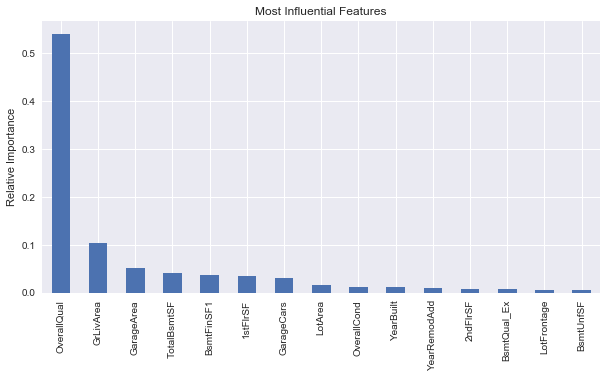

In [43]:
feature_imp = sorted(list(zip(x_train.columns, forest_2.feature_importances_)), key=lambda x: x[1], reverse=True)
importance = pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp])
largest_feat = importance.nlargest(n=15)
largest_feat.plot(kind='bar',title = "Most Influential Features",figsize=(10,5))
plt.ylabel('Relative Importance')

In [44]:
#List similar important features
similar_coef = [item for item in largest_feat.index if item in largest_coef.index]
similar_coef

['OverallQual',
 'GrLivArea',
 'GarageArea',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'GarageCars',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd']

In [45]:
#List different important features
different_coef = [item for item in largest_feat.index if item not in largest_coef.index]
different_coef1= [item for item in largest_coef.index if item not in largest_feat.index]
different_coef.append(different_coef1)
different_coef

['1stFlrSF',
 '2ndFlrSF',
 'BsmtQual_Ex',
 'LotFrontage',
 'BsmtUnfSF',
 ['Foundation_PConc',
  'Neighborhood_Crawfor',
  'Fireplaces',
  'MSSubClass',
  'OpenPorchSF']]

With 10 of the features in common, it appears that both models do a decent job of finding the same patterns in the data. With 5 different features each, there is room for improvement in the models.   
   
#### Reliability of Models   
   
My final Elastic Net and Random Forest Models have returned very accurate estimates for both the training and test sets. With accuracy of predicting a house price within $10,000, this can be a very reliable tool for someone wanting an estimate of their house.    

The results of these models do lead me to trust their results due to the low RMSEs that they are returning. However, if I were Zillow or another business that profits off of accurate pricing of houses, then I might not feel as comfortable with a $10,000 average error. It is a close approximation, but maybe not precise enough as 10,000 dollars is not pocket change for the normal person.

## Test Data Predictions

In order to properly use the models that I created, I have to scale the test data in the same way that the train data was. To do so, I use the scaler.fit(x_train) that was used previously.   
   
There is a problem, however, there appear to be more variables in the train data than the test data due to different dummies that were created. To examine this problem, I compile a list of the columns for each dataset and then find what ones are in the train set but not in the test. Those dummy variables are then created and filled with the value 0. The test data can then be scaled properly.

In [46]:
#Gather list of all variables in train
all_train_columns = []
for abc in predictors:
    all_train_columns.append(abc)

#Gather list of all variables in test
all_test_columns = []
for xyz in final_test_data:
    all_test_columns.append(xyz)

In [47]:
#Only take variables that are in train and not test
uncommon = [item for item in all_train_columns if item not in all_test_columns]

In [48]:
#Show uncommon variables
uncommon

['HouseStyle_2.5Fin',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other']

In [49]:
#Create new variables in test and set equal to 0
final_test_data['HouseStyle_2.5Fin'] = 0
final_test_data['Exterior1st_ImStucc'] = 0
final_test_data['Exterior1st_Stone'] = 0
final_test_data['Exterior2nd_Other'] = 0

In [50]:
#Scale final testing data
scaled_final = scaler.transform(final_test_data)

### Predict Test

I use the models of Elastic Net and Random Forest because they have the lowest RMSE. I will submit both to Kaggle to see which gives the better prediction.

In [51]:
#Prediction for Elastic Net
estimated_prices = np.exp(ENSTest.predict(scaled_final))

In [52]:
#The ID will be used as a column in the submission csv
ID = final_test_data['Id']

#Create dataframe with just ID and SalePrice
Output = pd.DataFrame({"ID": ID, "SalePrice": estimated_prices})
#Export to CSV
Output.to_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/kaggle_sub_EN.csv",index=False)

In [53]:
#Prediction for Random Forest
est_prices = np.exp(gridsearch3.predict(scaled_final))

In [54]:
#Create and Export to csv
Output = pd.DataFrame({"ID": ID, "SalePrice": est_prices})
Output.to_csv("/Users/tristanmoser/files/coding/machine_learning/HW2/kaggle_sub_RF.csv", index=False)

# Kaggle   
   
I submitted to Kaggle and my Elastic Net predictions scored a RMSE of 0.15362